In [17]:
# pip install --only-binary=numpy facenet-pytorch
 

In [18]:
import warnings
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import os

from Utilities import Utilities
from FaceAlignment import FaceAlignment
from ArcFace import ResNetWithArcFace, CelebAHeatmapDataset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
identical_path = os.path.join('https://drive.google.com/drive/folders/1AcgU-IkL_SFHSpqfuiTOpOzIqh7NKOM3?usp=drive_link')
different_path = os.path.join('https://drive.google.com/drive/folders/1Y92KkhCx7p2VSZdYQF7x-7ezwE0wUG51?usp=drive_link')
identifity_identical = os.path.join(identical_path, 'identical_faces.csv')
different_identical = os.path.join(different_path, 'different_faces.csv')


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
class Pipeline:
    def __init__(self, identifity_path, image_path, input_size, output_size):
        self.detector = MTCNN(
                                image_size=160,
                                keep_all=True,        # Возвращает все обнаруженные лица
                                min_face_size=15,  # Минимальный размер лица
                                thresholds=[0.6, 0.7, 0.7],  # Пороги для трёх каскадов
                                factor=0.709,      # Масштабный коэффициент
                                select_largest=True, # Выбирать самое большое лицо
                                post_process=True   # Нормализация вывода)
)
        self.image_path = image_path
        self.input_size = input_size
        self.output_size = output_size
        self.scale_factor = input_size / output_size
        self.identifity_path = identifity_path

        self.crop_faces = []
        self.aligned_faces = []
        self.transform = transforms.Compose([
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def detect_images(self, images, show=False):
        if show:
           image = mpimg.imread(os.path.join(self.image_path, images))
           plt.imshow(image)
           plt.axis('off')  
           plt.show()  
        pil_image = Image.open(os.path.join(self.image_path, images)).convert('RGB')
        image_np = np.array(pil_image)  # RGB
        image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        image_bgr = image_bgr.astype(np.uint8)
        
        with warnings.catch_warnings():
             warnings.filterwarnings("ignore", message="I/O operation on closed file")
             boxes, _, face_landmarks = self.detector.detect(image_bgr,  landmarks=True)

        for i in range(boxes.shape[0]):
            box = boxes[i].astype(int)
            crop = transforms.functional.crop(pil_image,
                                       box[1], box[0],box[3]-box[1], box[2]-box[0]) 
            
            # Преобразуем landmark'и в массив [(x1, y1), (x2, y2), ...]
            landmarks = face_landmarks[i].astype(int)

            # Масштабируем landmark'и под input_size
            crop_shape = crop.size  # (width, height)
             

            landmarks[:, 0] -= box[0]  # x
            landmarks[:, 1] -= box[1]  # y               
            landmarks[:, 0] = (landmarks[:, 0] * self.input_size / crop_shape[0]).astype(int)  # x
            landmarks[:, 1] = (landmarks[:, 1] * self.input_size / crop_shape[1]).astype(int)  # y
            landmarks_for_heatmap = landmarks / self.scale_factor

            # Создаём heatmap'ы
            heatmaps = Utilities.landmarks_to_heatmaps((self.output_size, self.output_size), landmarks_for_heatmap, sigma=1.5)

            # Преобразуем изображение в тензор
            image_tensor = self.transform(crop)

            self.crop_faces.append((image_tensor, torch.from_numpy(heatmaps).float(), torch.from_numpy(landmarks).float()))
            
        self.fa = FaceAlignment(self.crop_faces)

    def face_alignment(self, show=False):
        for idx in range(len(self.crop_faces)):
           self.fa.align_face_by_rotation(idx)
           if show:
               self.fa.show_align_face_by_rotation(idx)

    def load_arc_face(self):
        self.arcface_model = ResNetWithArcFace(self.identifity_path, self.image_path, m=0.3)
        self.arcface_model.load_state_dict(
            torch.load(os.path.join('models', 'ArcFace.pt')))
        self.arcface_dataset = CelebAHeatmapDataset(self.fa.aligned_faces) 

    def predict(self, idx, show=False):
        return self.arcface_model.predict(self.arcface_dataset[idx], idx, show)
        
    def get_embeding(self, idx):
        return self.arcface_model.get_embeddings(self.arcface_dataset[idx])    

    def emb_compare(self, vec1, vec2):
         # Вычисляем косинусное сходство
        similarity = F.cosine_similarity(vec1, vec2, dim=1)
        # Преобразуем в число
        return similarity.item()


##### Одинаковое лицо

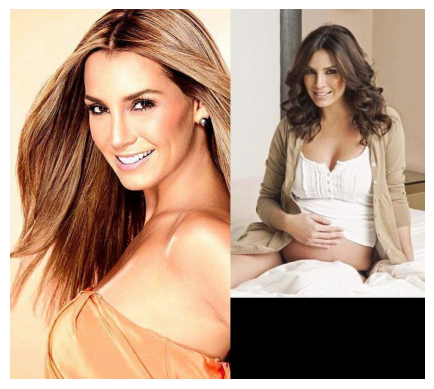

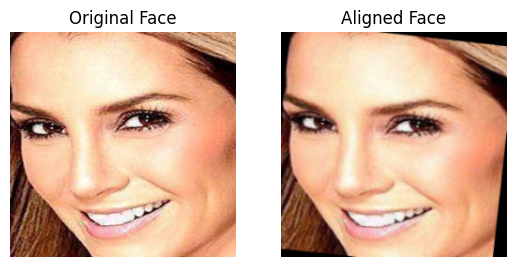

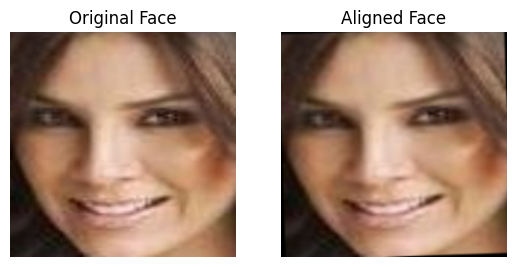

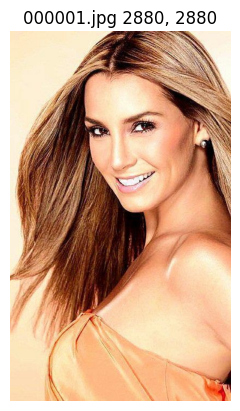

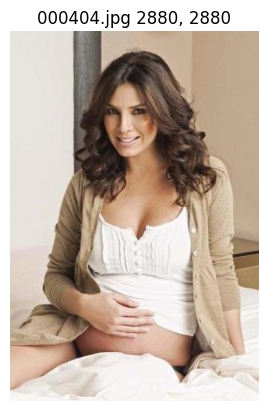

Идентификатор 1-го изображения: 2880
Идентификатор 2-го изображения: 2880
Косинусное сходство:  0.6243


In [22]:
identical_faces = Pipeline(identifity_identical, identical_path, 256, 64)
identical_faces.detect_images('identical_faces.jpg', True)
identical_faces.face_alignment(True)
identical_faces.load_arc_face()
_, _, id0 = identical_faces.predict(0, True)
_, _, id1 = identical_faces.predict(1, True)
print(f'Идентификатор 1-го изображения: {id0.item()}')
print(f'Идентификатор 2-го изображения: {id1.item()}')
print(f'Косинусное сходство: {identical_faces.emb_compare(identical_faces.get_embeding(0), identical_faces.get_embeding(1)) : .4f}')

In [23]:
del identical_faces

#### Разные лица

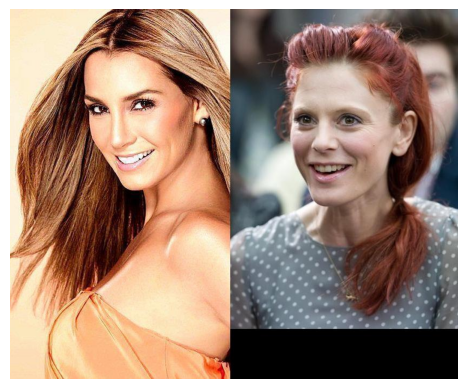

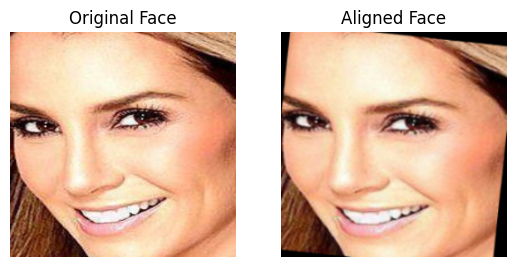

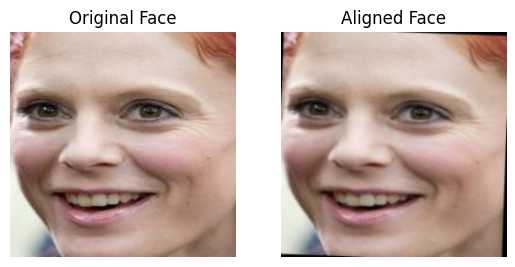

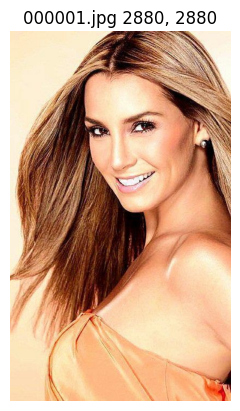

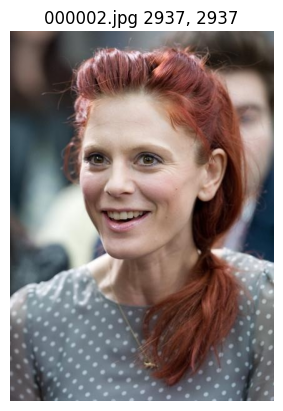

Идентификатор 1-го изображения: 2880
Идентификатор 2-го изображения: 2937
Косинусное сходство:  0.0425


In [24]:
different_faces = Pipeline(different_identical, different_path, 256, 64)
different_faces.detect_images('different_faces.jpg', True)
different_faces.face_alignment(True)
different_faces.load_arc_face()
_, _, id0 = different_faces.predict(0, show=True)
_, _, id1 = different_faces.predict(1, True)
print(f'Идентификатор 1-го изображения: {id0.item()}')
print(f'Идентификатор 2-го изображения: {id1.item()}')
print(f'Косинусное сходство: {different_faces.emb_compare(different_faces.get_embeding(0), different_faces.get_embeding(1)) : .4f}')